In [1]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape,
                                     Bidirectional, LSTM, Dense, Dropout)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/path/to/mel_spectrogram_sax.h5"


In [3]:
def load_mel_spectrograms_from_h5(file_path, label):
    with h5py.File(file_path, "r") as h5_file:
        X = [np.array(h5_file[key]) for key in h5_file.keys()]
    y = [label] * len(X)
    return np.array(X), np.array(y)

In [12]:
dataset_paths = [
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_piano.h5", "piano"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_guitar.h5", "guitar"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_sax.h5", "sax"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_sax2.h5", "sax"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_trong.h5", "trong"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/mel_spectrogram_violin.h5", "violin"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/sao_mel_spectrogram.h5", "sao"),
    ("/content/drive/MyDrive/Bách Khoa/HMKPDL/Data/trumpet_mel_spectrogram.h5", "trumpet")
]

In [14]:
all_data = []
all_labels = []
for path, label in dataset_paths:
    X_part, y_part = load_mel_spectrograms_from_h5(path, label)
    all_data.append(X_part)
    all_labels.append(y_part)

In [15]:
X = np.concatenate(all_data, axis=0).astype("float32")
y = np.concatenate(all_labels, axis=0)

In [16]:
X = X / np.max(X)
X = X[..., np.newaxis]  # Shape becomes (samples, 128, 130, 1)

In [17]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_encoded, random_state=42)

In [19]:
def build_crnn_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    # Reshape for RNN input: (batch, time, features)
    shape = x.shape
    x = Reshape((shape[1], shape[2]*shape[3]))(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_crnn_model(input_shape=(128, 130, 1), num_classes=y.shape[1])


In [20]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.5831 - loss: 1.2004 - val_accuracy: 0.0851 - val_loss: 2.7404
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8210 - loss: 0.5803 - val_accuracy: 0.5254 - val_loss: 1.2000
Epoch 3/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8776 - loss: 0.3954 - val_accuracy: 0.8962 - val_loss: 0.3395
Epoch 4/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9036 - loss: 0.3187 - val_accuracy: 0.9116 - val_loss: 0.3052
Epoch 5/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9277 - loss: 0.2568 - val_accuracy: 0.9329 - val_loss: 0.2286
Epoch 6/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9414 - loss: 0.1993 - val_accuracy: 0.9345 - val_loss: 0.2110
Epoch 7/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9505 - loss: 0.1705 - val_accuracy: 0.9336 - val_loss: 0.2134
Epoch 8/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9557 - loss: 0.1462 - 

In [21]:
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9654 - loss: 0.1199
Test Accuracy: 0.9564648270606995


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


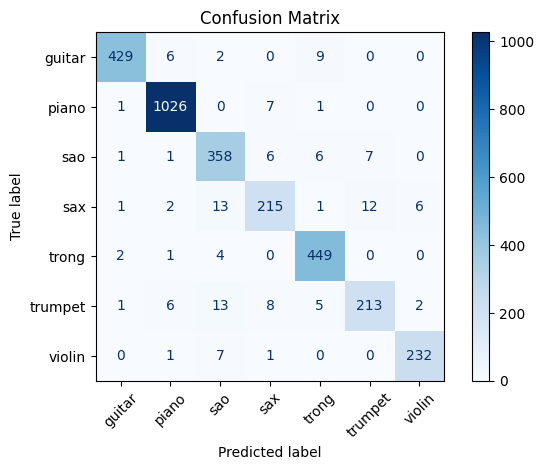

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = le.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [22]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
